<a id="1"></a> <br>
## Import Libraries

In [38]:
# Data Analysis      
import pandas as pd          # data analysis library for handling structured data             
import numpy as np           # mathematical library for working with numerical data
from metrics import *

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import missingno as msno    #visualize missing data
from sklearn.metrics import mean_squared_error, r2_score 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000) 


# Function to filter out LightGBM warnings
def suppress_lightgbm_warnings(message, category, filename, lineno, file=None, line=None):
    return 'LightGBM' not in str(message)

warnings.showwarning = suppress_lightgbm_warnings


In [39]:
import os

os.chdir(r"C:\Users\pault\OneDrive - University of Oklahoma\GRA - Bio-Manufacturing\1. ML-Cytovance-OU-Research")

> Drop invariant columns

In [40]:
# drop invariant columns 
def drop_invariant_columns(df):
    """
    This function takes a list of DataFrames and drops specified invariant columns from each DataFrame.

    Parameters:
    experiment_data (list): List of pandas DataFrames.
    invariant_cols (list): List of column names to be dropped from each DataFrame.

    Returns:
    list: A new list of DataFrames with invariant columns dropped.
    """
    invariant_cols = ['input_vessel_type',	'input_vessel_volume',	'input_vessel_name',	'input_agitation_rpm',	'input_DO_%',	
                  'input_pH_setpoint',	'input_gas_flow',	'input_air_%',	'input_O2',	'input_Temp_c',	'input_media_type',	
                  'input_feed_type',	'input_glucose_limit']
    

    # Create a copy of the DataFrame to avoid modifying the original data.
    updated_df = df.drop(columns=invariant_cols, axis=1)
    return updated_df




### Missing Value Imputation

In [41]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor    

def convert_WCW_zero(df):
    df['output_WCW_gl'] = df.apply(lambda row: 0 if row['input_Timepoint (hr)'] in [0,1, 2] else row['output_WCW_gl'], axis=1)
    # df['output_WCW_gl'] = df.apply(lambda row: 0 if row.name in [pd.Timestamp("2024-01-01 00:00:00"), pd.Timestamp("2024-01-01 01:00:00"), pd.Timestamp("2024-01-01 02:00:00")] else row['output_WCW_gl'], axis=1)
    return df


def impute_missing_values_iteratively(X_a): #or (X, Columns)
    
    X_a = convert_WCW_zero(X_a)
    X = X_a.copy()
    
    for col in X.columns: 
        if X[col].isnull().any() and X[col].dtype == 'object' and col != 'input_Timepoint (hr)':  
            X[col] = pd.to_numeric(X[col], errors='coerce')

    
    imputer = IterativeImputer(
        # estimator = RandomForestRegressor() 
        estimator=RandomForestRegressor(n_estimators=100, random_state=0), # the estimator to predict the NA
        initial_strategy='mean', # how will NA be imputed in step 1
        max_iter=10, # number of cycles
        imputation_order='ascending', # the order in which to impute the variables
        n_nearest_features=None, # whether to limit the number of predictors
        skip_complete=True, # whether to ignore variables without NA
        random_state=0,)
    
    # Select columns that are now either originally numeric or successfully converted from object
    numeric_cols = X.select_dtypes(include=['number']).columns
    # select only the columns with missing values to be imputed
    # X_cols = X[columns]
    X_imputed = imputer.fit_transform(X[numeric_cols]) #or X_cols
    X_a[numeric_cols] = X_imputed
    
    return X_a



> Trasforming time variable (using sine and cosine method)

In [42]:

def add_cyclical_time_features(df, time_column, cycle_period):
    """
    Adds cyclical time features to a DataFrame based on a specified time column and cycle period.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the time column.
    - time_column (str): The name of the column in df that contains time values.
    - cycle_period (float): The period of the cycle in the same units as the time column (e.g., 48 hours).

    Returns:
    - pd.DataFrame: A DataFrame with two new columns appended, representing the sine and cosine transformations of the time column.
    """
    
    # Ensure the time column exists in the DataFrame
    if time_column not in df.columns:
        raise ValueError(f"The specified time column '{time_column}' does not exist in the DataFrame.")

    # Apply sine and cosine transformations
    df[f'{time_column}_sin'] = np.sin(2 * np.pi * df[time_column] / cycle_period)
    df[f'{time_column}_cos'] = np.cos(2 * np.pi * df[time_column] / cycle_period)
    df.drop(columns = time_column, inplace=True)

    return df

# Example usage
# Assuming your DataFrame is named df and the time column is named 'time'
# df_combined_extra = add_cyclical_time_features(df_combined_extra, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)


> Scale and Concat

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Use StandardScaler for this
scale_cols = ['output_WCW_gl', 'output_agitation', 'output_air_%', 'output_D0_%', 'output_gasflow', 'output_O2', 'output_Ph', 
              'output_feed_%', 'output_feed', 'output_Temp', 'output_glycerol_gl', 
              'output_glucose_gl', 'output_acetate_mmol_l', 'output_phosphate_mmol_l']

def scale_and_concat(X, columns_to_transform = scale_cols, train = False, scaler = None):
    """
    Scales selected columns in a DataFrame using StandardScaler and concatenates them with the rest of the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        columns_to_transform (list): List of column names to be scaled.

    Returns:
        pandas.DataFrame: The concatenated DataFrame with scaled columns.
    """
    
    # Filter out columns in 'columns_to_transform' that are not present in 'X'
    valid_columns = [col for col in columns_to_transform if col in X.columns]
    
    if train == True:
        # scaler = MinMaxScaler() # Initialize the scaler 
        scaler = StandardScaler()   # Initialize the scaler
        scaler.fit(X[valid_columns])  # Fit only on the training set
    else:
        scaler = scaler

    # Create a copy of the original DataFrame
    df_concatenated = X.copy()

    # Scale the selected columns
    scaled_columns = scaler.transform(X[valid_columns])

    # Create a DataFrame with the scaled columns
    df_scaled = pd.DataFrame(scaled_columns, columns=valid_columns, index=X.index)
            
    # Concatenate the scaled columns with the rest of the DataFrame
    df_concatenated = pd.concat([df_concatenated.drop(columns=valid_columns, axis = 1), df_scaled], axis=1)

    if train == True:
        return df_concatenated, scaler
    else:
        return df_concatenated
    



> Polynomial Feature Extraction

In [44]:
from sklearn.preprocessing import PolynomialFeatures

# Select the most important features
important_features = ['output_WCW_gl', 'output_phosphate_mmol_l', 'output_gasflow', 
                      'output_agitation', 'output_feed_%', 'output_glycerol_gl', 'output_glucose_gl', 
                      'input_Timepoint (hr)_sin', 'input_Timepoint (hr)_cos']


def add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=None, prefix='poly_'):
    """
    Adds polynomial features up to a specified degree to a subset of columns in training and testing Pandas DataFrames.
    
    Parameters:
        X_train (Pandas DataFrame): The training DataFrame.
        X_test (Pandas DataFrame): The testing DataFrame.
        degree (int): The maximum degree of polynomial features to generate.
        columns (list of str): The names of the columns to generate polynomial features for.
        prefix (str): Prefix for the new polynomial feature columns.
        
    Returns:
        tuple: A tuple containing the new training and testing DataFrames with added polynomial features.
    """
    if columns is None:
        # Optionally, define default columns if none provided, or remove this block
        columns = X_train.columns  # This will include all columns if not specified

        # Filter out columns in 'columns_to_transform' that are not present in 'X'
    valid_columns = [col for col in columns if col in X_train.columns]
    
    # Extract the specified columns for transformation
    X_train_subset = X_train[valid_columns]
    X_test_subset = X_test[valid_columns]

    # Initialize PolynomialFeatures transformer
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # Fit and transform the training data
    X_train_poly = poly.fit_transform(X_train_subset)
    # Transform the test data based on the fitted transformer
    X_test_poly = poly.transform(X_test_subset)

    # Generate new column names
    poly_feature_names = [prefix + name for name in poly.get_feature_names_out(valid_columns)]

    # Create DataFrames for polynomial features
    poly_train_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train_subset.index)
    poly_test_df = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=X_test_subset.index)

    # Concatenate polynomial features with the original DataFrames excluding transformed columns
    new_X_train = pd.concat([X_train.drop(columns=valid_columns), poly_train_df], axis=1)
    new_X_test = pd.concat([X_test.drop(columns=valid_columns), poly_test_df], axis=1)

    return new_X_train, new_X_test




> Feature Selection

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

def feature_selection_with_model(X_train, y_train, X_test, threshold=None):
    """
    Performs feature selection using a model-based method on the training set
    and applies the same selection to the test set.

    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target.
        X_test (DataFrame): Test features.
        threshold (str or float, optional): The threshold value to use for feature selection.
            If 'median' (string), select features whose importance is greater than the median.
            If None, uses the default threshold of the model. Defaults to None.

    Returns:
        X_train_selected (DataFrame): Training set with selected features.
        X_test_selected (DataFrame): Test set with selected features.
        selected_features (list): List of selected feature names.
    """
    # Initialize the model you want to use for feature selection
    model = RandomForestRegressor(random_state=42)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Initialize SelectFromModel with the fitted model and threshold
    selector = SelectFromModel(model, threshold=threshold, prefit=True)

    # Transform the training and test sets using the selector
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Get the selected feature names
    selected_features = X_train.columns[selector.get_support()]

    # Transform back to DataFrames for compatibility with the rest of your code
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

    return X_train_selected, X_test_selected, selector








from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor  # Or any other suitable estimator

def feature_selection_rfe(X_train, y_train, X_test, num_features_to_select = None):
    """
    Performs feature selection using Recursive Feature Elimination (RFE) on the training set and applies the selection to both training and test sets.

    Args:
        X_train (pd.DataFrame): The training features.
        y_train (pd.Series): The training target variable.
        X_test (pd.DataFrame): The test features.
        num_features_to_select (int): The number of features to select with RFE.

    Returns:
        X_train_selected (pd.DataFrame): The transformed training set with selected features.
        X_test_selected (pd.DataFrame): The transformed test set with selected features.
    """
    # Initialize the base estimator for RFE
    estimator = RandomForestRegressor()

    # Initialize RFE with the chosen estimator and number of features to select
    rfe = RFE(estimator, n_features_to_select=num_features_to_select, step=1)

    # Fit RFE on the training data
    rfe.fit(X_train, y_train)

    # Transform training and test sets to contain only the selected features
    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    # Retrieve the names of the selected features to maintain a DataFrame structure
    selected_features = X_train.columns[rfe.support_]

    # Convert the arrays back to DataFrames for compatibility and readability
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

    return X_train_selected, X_test_selected, rfe






> Model Selection

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Assuming y_train and X_train are defined and contain your training data
def fit_sarimax_model(X_train, y_train, X_test, y_test):
    # Define the model
    model = SARIMAX(
        y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
    )
    # Fit the model
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(
        steps=len(X_test), exog=X_test
    ).predicted_mean.values
    
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for SARIMAX: {mse}")
    # print(f"Root Mean Squared Error for SARIMAX: {rmse}")
    # print(f"R2 for SARIMAX: {r2}")
    return mse, rmse, r2, model_fit 


# Function for XGBoost regression
def train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index = None):
    # Instantiate the XGBoost regressor with the given parameters
    if params is not None:
            xg_reg = xgb.XGBRegressor(**params)
    else:
        xg_reg = xgb.XGBRegressor()
        
    xg_reg.fit(X_train, y_train)

    # Predictions
    y_pred = xg_reg.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for XGBoost: {mse}")
    # print(f"Root Mean Squared Error for XGBoost: {rmse}")
    # print(f"R2 for XGBoost: {r2}")
    
    # Collecting model information
    model_info = {'Model Name': xg_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    
    print(f"Mean Squared Error for XGBoost: {mse}")
    print(f"Root Mean Squared Error for XGBoost: {rmse}")
    print(f"R2 Score for XGBoost: {r2}")
    print(' ')
        
    if hasattr(xg_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = xg_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    # Include cross-validation fold index if provided
    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
    return model_info, xg_reg


# Function for Multiple Linear Regression
# def train_evaluate_linear_regression(X_train, y_train, X_test, y_test):

#     # Instantiate the Linear Regression model
#     lin_reg = LinearRegression()
#     lin_reg.fit(X_train, y_train)

#     # Predictions
#     y_pred = lin_reg.predict(X_test)

#     # Evaluate the performance
#     mse = mean_squared_error(y_test, y_pred, squared=True)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for Linear Regression: {mse}")
    # print(f"Root Mean Squared Error for Linear Regression: {rmse}")
    # print(f"R2 for Linear Regression: {r2}")
#     return mse, rmse, r2, lin_reg


from pycaret.regression import *
from pycaret.regression import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, save_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

def pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=None):
    # Combine X and y into a single DataFrame for PyCaret setup
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = X_test.copy()
    
    # Setup PyCaret environment
    exp_reg = setup(data=train_df, target=y_train.name, session_id=123, fold_shuffle = False,
                    preprocess=False, verbose=False, data_split_shuffle = False, 
                    use_gpu = True)

    # Compare models and select the best one based on a specified metric, for example, 'RMSE'
    best_model = compare_models(exclude=['lightgbm'], sort='RMSE', cross_validation=False, verbose=False)

    # Train the best model on the entire training set
    final_model = finalize_model(best_model)
    
    # Predict on test set
    predictions = predict_model(final_model, data=test_df, verbose=False) 

    # Evaluate predictions
    mse = mean_squared_error(y_test, predictions['prediction_label'])
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, predictions['prediction_label']) 
    
    # Collecting model information
    model_info = {'Model Name': best_model.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    
    # Display evaluation metrics
    print(f"Mean Squared Error for PyCaret: {mse}")
    print(f"Root Mean Squared Error for PyCaret: {rmse}")
    print(f"R2 Score for PyCaret: {r2}")
    print(' ')
    if hasattr(best_model, 'get_params'):  # Check if the model has 'get_params' method
        model_params = best_model.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
                
    return model_info, final_model


def train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index = None):
    # Instantiate the Random Forest Regressor with the given parameters
    
    if params is not None:
            rf_reg = RandomForestRegressor(**params)
    else:
        rf_reg = RandomForestRegressor()

    rf_reg.fit(X_train, y_train)

    # Predictions
    y_pred = rf_reg.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Collecting model information
    model_info = {'Model Name': rf_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    print(f"Mean Squared Error for RandomForest: {mse}")
    print(f"Root Mean Squared Error for RandomForest: {rmse}")
    print(f"R2 Score for RandomForest: {r2}")
    print(' ')
        
    if hasattr(rf_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = rf_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
                  
    return model_info, rf_reg


def train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index = None):
    # Instantiate the Extra Trees Regressor with the given parameters
    
    if params is not None:
        et_reg = ExtraTreesRegressor(**params)
    else:
        et_reg = ExtraTreesRegressor()
        
    et_reg.fit(X_train, y_train)

    # Predictions
    y_pred = et_reg.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Collecting model information
    model_info = {'Model Name': et_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}

    print(f"Mean Squared Error for ExtraTreesRegressor: {mse}")
    print(f"Root Mean Squared Error for ExtraTreesRegressor: {rmse}")
    print(f"R2 Score for ExtraTreesRegressor: {r2}")
    print(' ')
        
    if hasattr(et_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = et_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
                    
    return model_info, et_reg


import os
import joblib

# def save_models_and_info(models_dict, model_infos_dict, directory="saved_models"):
#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save each model using joblib
#     for model_name, model in models_dict.items():
#         model_filename = os.path.join(directory, f"{model_name}.joblib")
#         joblib.dump(model, model_filename)
#         print(f"Model '{model_name}' saved to '{model_filename}'")

#     # Convert model_infos_dict into a DataFrame
#     model_infos_df = pd.DataFrame.from_dict(model_infos_dict, orient='index')

#     # Save the DataFrame as a CSV file
#     info_filename = os.path.join(directory, "model_infos.csv")
#     model_infos_df.to_csv(info_filename)
#     print(f"Model information saved to '{info_filename}'") 


def save_models_and_info(models_dict, model_infos_dict, directory):
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Initialize an empty list to collect all model info dataframes
    all_model_infos = []

    # Iterate over the model_infos_dict to process each list of dictionaries
    for model_key, infos in model_infos_dict.items():
        for model_info in infos:
            model_info_df = pd.DataFrame([model_info])
            model_info_df['Model Key'] = model_key  # Add a column for the model key to track it
            all_model_infos.append(model_info_df)

    # Concatenate all the individual dataframes into one
    all_model_infos_df = pd.concat(all_model_infos, ignore_index=True)
    
    # Save the concatenated DataFrame to CSV
    model_infos_csv_path = os.path.join(directory, 'model_infos.csv')
    all_model_infos_df.to_csv(model_infos_csv_path, index=False)
    print(f"Model information saved to {model_infos_csv_path}")

    # Save models using joblib
    for model_key, model in models_dict.items():
        model_file_path = os.path.join(directory, f"{model_key}.joblib")
        joblib.dump(model, model_file_path)

    print(f"Models saved in the directory: {directory}")





> Data 1: Entire Dataset

In [27]:
def suppress_lightgbm_warnings(message, category, filename, lineno, file=None, line=None):
    return 'LightGBM' not in str(message)

warnings.showwarning = suppress_lightgbm_warnings


experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {}
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        
        print(f'Performance of the models on fold {fold}:')
        # Train and evaluate models
        pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 
        
        models_dict[f'PyCaret_{fold}'] = pycaret_model
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model
        
        model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)        
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info)
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 1")
    
    return models_dict, model_infos_dict
    
models_dict_1, model_infos_dict_1 = cross_validation_with_shuffling(experiment_names, n_splits=5)



Performance of the models on fold 0:
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

In [28]:
# models_dict_1

> Data 2: removed C1-4,5,6 and all C2 batches

In [29]:
def suppress_lightgbm_warnings(message, category, filename, lineno, file=None, line=None):
    return 'LightGBM' not in str(message)

warnings.showwarning = suppress_lightgbm_warnings



experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        
        print(f'Performance of the models on fold {fold}:')
        # Train and evaluate models
        pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 


        models_dict[f'PyCaret_{fold}'] = pycaret_model
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model  
        
        model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)        
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info)
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 2")
    
    return models_dict, model_infos_dict
    
models_dict_2, model_infos_dict_2 = cross_validation_with_shuffling(experiment_names, n_splits=5)



Performance of the models on fold 0:
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

> Data 3: removed all C2 batches

In [30]:


experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    # 'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        
        print(f'Performance of the models on fold {fold}:')
        # Train and evaluate models
        pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 


        models_dict[f'PyCaret_{fold}'] = pycaret_model
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model
        
        model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)        
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info) 
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 3")
    
    return models_dict, model_infos_dict
    
models_dict_3, model_infos_dict_3 = cross_validation_with_shuffling(experiment_names, n_splits=5)



Performance of the models on fold 0:
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

> Data 4: Removed all C2 batches + Glycerol columns

In [47]:



experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    # 'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict


def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.drop(columns=['output_glycerol_gl'], inplace=True)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        
        print(f'Performance of the models on fold {fold}:')
        # Train and evaluate models
        pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 


        models_dict[f'PyCaret_{fold}'] = pycaret_model
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model
        
        model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)        
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info) 
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 4")
    
    return models_dict, model_infos_dict
    
models_dict_4, model_infos_dict_4 = cross_validation_with_shuffling(experiment_names, n_splits=5)




Performance of the models on fold 0:
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

> Data 5: Only Data with Agitation of 1200 rpm

In [32]:



experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {}
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        
        print(f'Performance of the models on fold {fold}:')
        # Train and evaluate models
        pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 


        models_dict[f'PyCaret_{fold}'] = pycaret_model
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model
        
        model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)        
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info) 
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 5")
    
    return models_dict, model_infos_dict
    
models_dict_5, model_infos_dict_5 = cross_validation_with_shuffling(experiment_names, n_splits=5)



Performance of the models on fold 0:
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

> Data 6: Entire Data without Glycerol variable

In [33]:



experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict


def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.drop(columns=['output_glycerol_gl'], inplace=True)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        
        print(f'Performance of the models on fold {fold}:')
        # Train and evaluate models
        pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 


        models_dict[f'PyCaret_{fold}'] = pycaret_model
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model
        
        model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)        
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info) 
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 6")
    
    return models_dict, model_infos_dict
    
models_dict_6, model_infos_dict_6 = cross_validation_with_shuffling(experiment_names, n_splits=5)



Performance of the models on fold 0:
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trai

In [78]:
# Batch 1:
# models_dict_1, model_infos_dict_1
batch_1 = pd.read_csv(r'models/Data 1/model_infos.csv')
batch_1['Batch'] = 'Data 1'

# # Batch 2:
# models_dict_2, model_infos_dict_2
batch_2 = pd.read_csv('models/Data 2/model_infos.csv')
batch_2['Batch'] = 'Data 2'

# # Batch 3:
# models_dict_3, model_infos_dict_3
batch_3 = pd.read_csv('models/Data 3/model_infos.csv')
batch_3['Batch'] = 'Data 3'

# # Batch 4:
# models_dict_4, model_infos_dict_4
batch_4 = pd.read_csv('models/Data 4/model_infos.csv')
batch_4['Batch'] = 'Data 4'

# # Batch 5:
# models_dict_5, model_infos_dict_5
batch_5 = pd.read_csv('models/Data 5/model_infos.csv')
batch_5['Batch'] = 'Data 5'

# # Batch 6:
# models_dict_6, model_infos_dict_6
batch_6 = pd.read_csv('models/Data 6/model_infos.csv')
batch_6['Batch'] = 'Data 6'


batch_concat = pd.concat([batch_1, batch_2, batch_3, batch_4, batch_5, batch_6], axis = 0, ignore_index=True)

In [79]:
batch_concat.groupby(['Batch', 'Model Name'])[['Mean Squared Error', 'Root Mean Squared Error', 'R2 Score']].mean()

Mean Squared Error  Root Mean Squared Error  R2 Score
Batch  Model Name                                                                      
Data 1 ExtraTreesRegressor                160.191904                12.655375  0.923609
       RandomForestRegressor              186.979436                13.674042  0.910835
       XGBRegressor                       159.502448                12.629428  0.923938
Data 2 ExtraTreesRegressor                121.847525                11.038457  0.928371
       GradientBoostingRegressor          124.479583                11.157042  0.926824
       RandomForestRegressor              114.820067                10.715413  0.932502
       XGBRegressor                       104.309814                10.213218  0.938681
Data 3 ExtraTreesRegressor                 91.058004                 9.542373  0.942628
       RandomForestRegressor               72.030307                 8.487067  0.954616
       XGBRegressor                        79.155457                 8.896935  0.950127
Data 4 ExtraTreesRegressor                 81.475429                 8.949243  0.948050
       RandomForestRegressor               69.577613                 8.305298  0.955546
       XGBRegressor                        83.164342                 9.089023  0.946832
Data 5 ExtraTreesRegressor                105.109304                10.252283  0.936326
       HuberRegressor                     149.904964                12.243568  0.909189
       RandomForestRegressor               92.313907                 9.608013  0.944077
       XGBRegressor                        91.176100                 9.548618  0.944766
Data 6 ExtraTreesRegressor                123.525013                11.107976  0.938883
       RandomForestRegressor              186.887036                13.670663  0.907533
       XGBRegressor                       187.913291                13.708147  0.907026

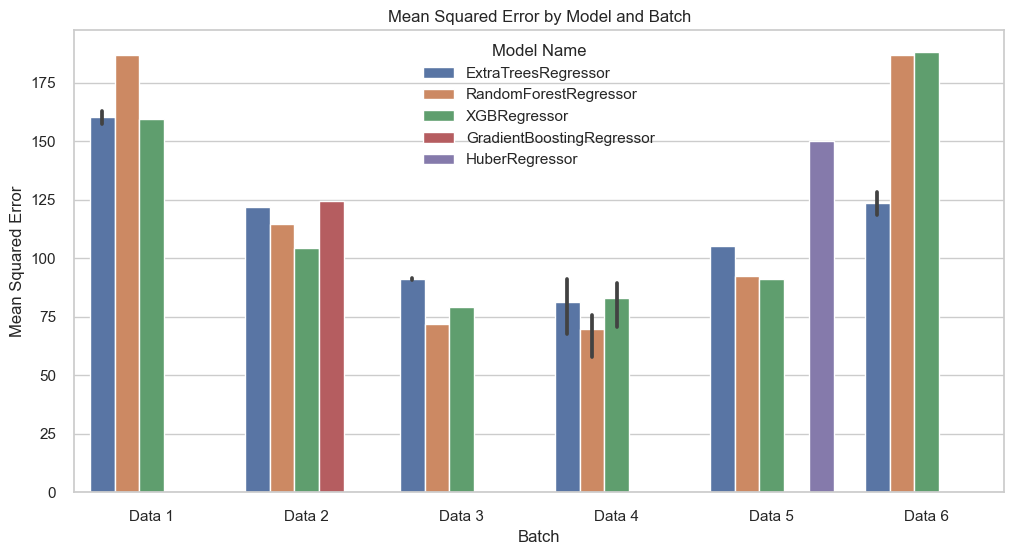

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'batch_concat' is your DataFrame
sns.set(style="whitegrid")

# Plot for Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Batch', y='Mean Squared Error', hue='Model Name', data=batch_concat)
plt.title('Mean Squared Error by Model and Batch')
plt.legend(title='Model Name')
plt.show()

# Repeat similar plots for 'Root Mean Squared Error' and 'R2 Score'


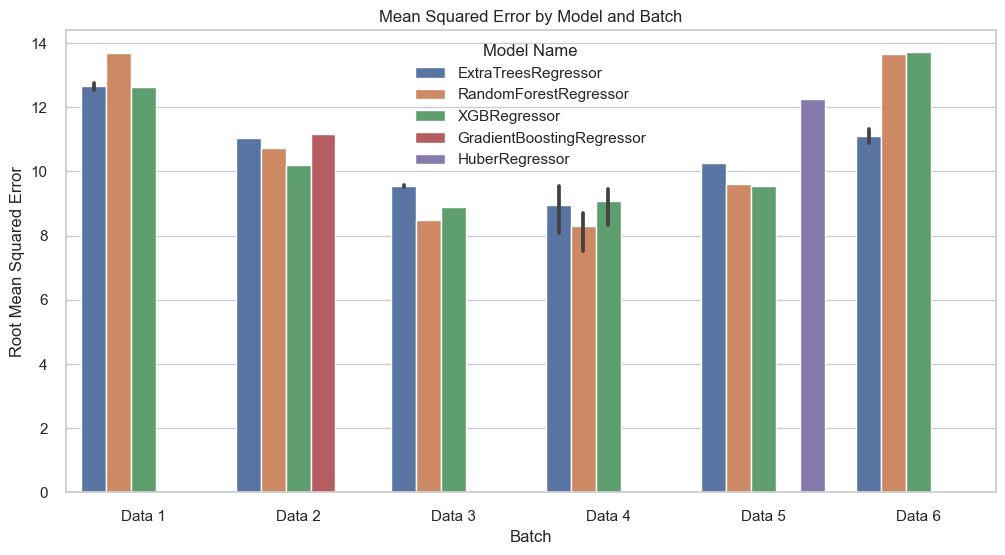

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'batch_concat' is your DataFrame
sns.set(style="whitegrid")

# Plot for Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Batch', y='Root Mean Squared Error', hue='Model Name', data=batch_concat)
plt.title('Mean Squared Error by Model and Batch')
plt.legend(title='Model Name')
plt.show()

# Repeat similar plots for 'Root Mean Squared Error' and 'R2 Score'


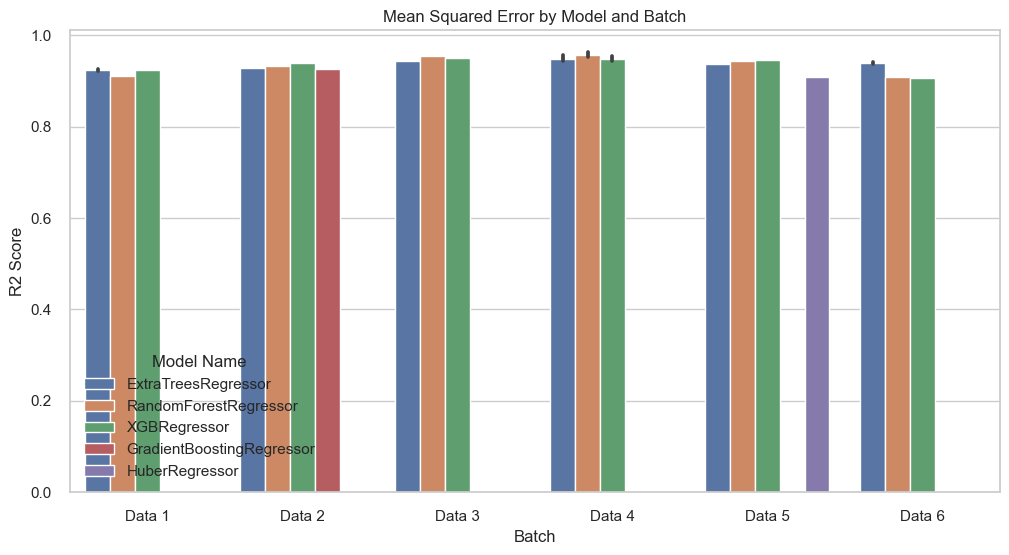

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'batch_concat' is your DataFrame
sns.set(style="whitegrid")

# Plot for Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Batch', y='R2 Score', hue='Model Name', data=batch_concat)
plt.title('Mean Squared Error by Model and Batch')
plt.legend(title='Model Name')
plt.show()

# Repeat similar plots for 'Root Mean Squared Error' and 'R2 Score'


In [52]:
batch_concat.sort_values(['Mean Squared Error', 'Root Mean Squared Error'], ascending=[True, True]).groupby('Batch').head(1)

Model Name  Mean Squared Error  Root Mean Squared Error  R2 Score                                   Model Parameters  Cross-Validation Fold Index       Model Key    Batch
60     ExtraTreesRegressor           42.485271                 6.518073  0.970902  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            0       PyCaret_0  Batch 4
41   RandomForestRegressor           72.030307                 8.487067  0.954616  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...                            0  RandomForest_0  Batch 3
83            XGBRegressor           91.176100                 9.548618  0.944766  {'objective': 'reg:squarederror', 'base_score'...                            0       XGBoost_0  Batch 5
23            XGBRegressor          104.309814                10.213218  0.938681  {'objective': 'reg:squarederror', 'base_score'...                            0       XGBoost_0  Batch 2
102    ExtraTreesRegressor          115.275704                10.736652  0.942965  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            0    ExtraTrees_0  Batch 6
0      ExtraTreesRegressor          155.566264                12.472621  0.925815  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            0       PyCaret_0  Batch 1

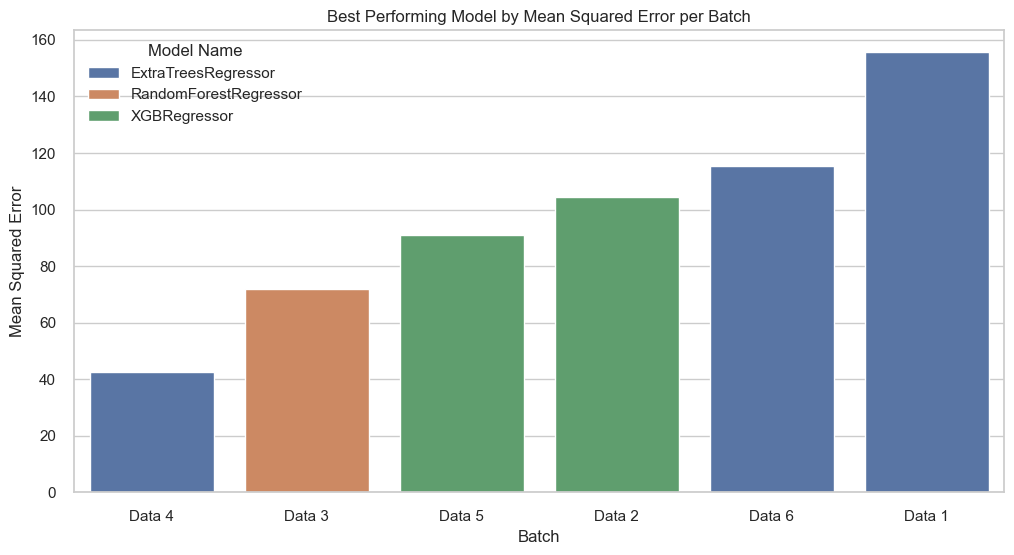

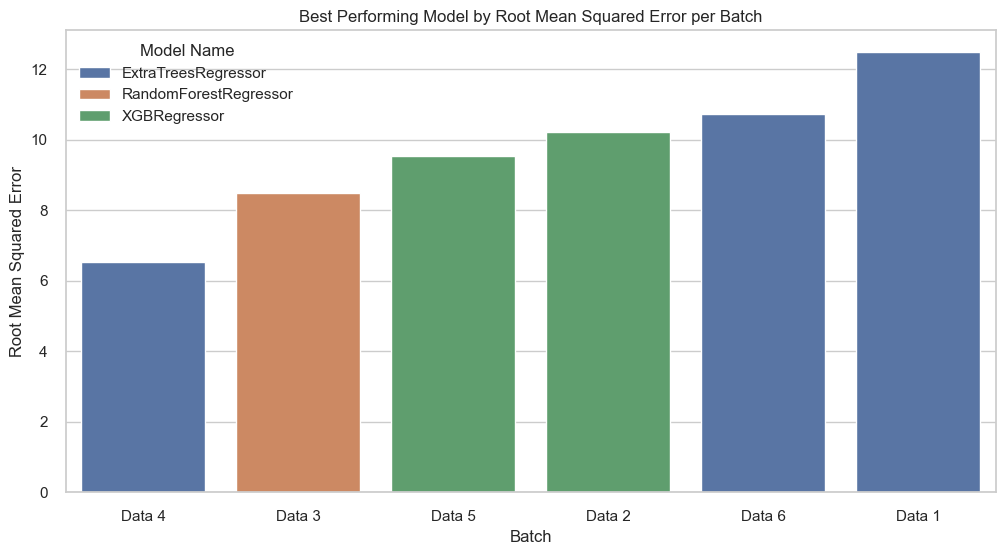

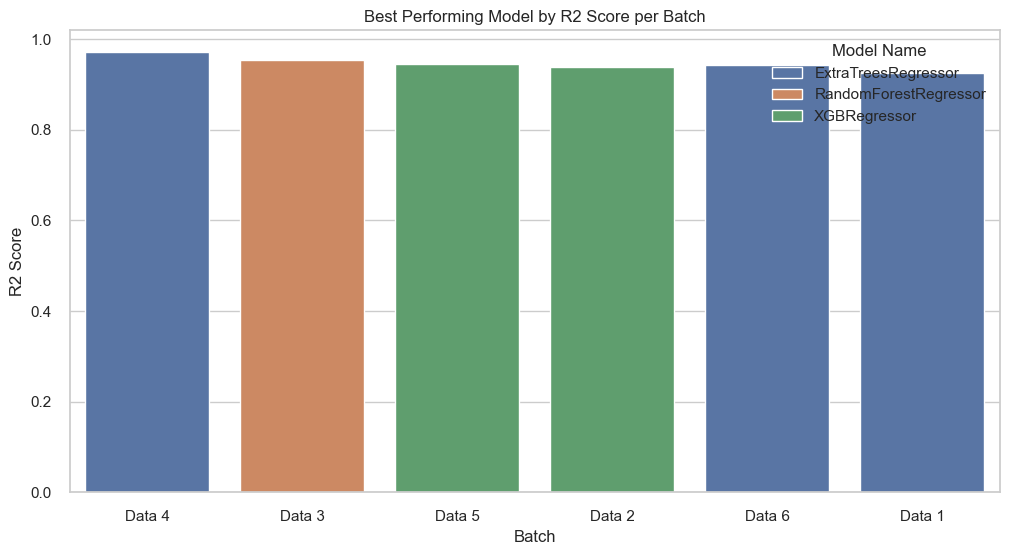

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'best_models' is your DataFrame containing the best model for each batch
best_models = batch_concat.sort_values(['Mean Squared Error', 'Root Mean Squared Error'], ascending=[True, True]).groupby('Batch').head(1)

# Plot for Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Batch', y='Mean Squared Error', hue='Model Name', data=best_models, dodge=False)
plt.title('Best Performing Model by Mean Squared Error per Batch')
plt.legend(title='Model Name')
plt.show()

# Plot for Root Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Batch', y='Root Mean Squared Error', hue='Model Name', data=best_models, dodge=False)
plt.title('Best Performing Model by Root Mean Squared Error per Batch')
plt.legend(title='Model Name')
plt.show()

# Plot for R2 Score
plt.figure(figsize=(12, 6))
sns.barplot(x='Batch', y='R2 Score', hue='Model Name', data=best_models, dodge=False)
plt.title('Best Performing Model by R2 Score per Batch')
plt.legend(title='Model Name')
plt.show()

In [63]:
batch_concat.query(' `Cross-Validation Fold Index` == 4' ).sort_values(['Mean Squared Error', 'Root Mean Squared Error'], ascending=[True, True]).head()

Model Name  Mean Squared Error  Root Mean Squared Error  R2 Score                                   Model Parameters  Cross-Validation Fold Index       Model Key    Batch
57  RandomForestRegressor           72.030307                 8.487067  0.954616  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...                            4  RandomForest_4  Batch 3
77  RandomForestRegressor           75.559184                 8.692479  0.952250  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...                            4  RandomForest_4  Batch 4
59           XGBRegressor           79.155457                 8.896935  0.950127  {'objective': 'reg:squarederror', 'base_score'...                            4       XGBoost_4  Batch 3
79           XGBRegressor           89.513945                 9.461181  0.943431  {'objective': 'reg:squarederror', 'base_score'...                            4       XGBoost_4  Batch 4
58    ExtraTreesRegressor           90.418200                 9.508848  0.943031  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            4    ExtraTrees_4  Batch 3

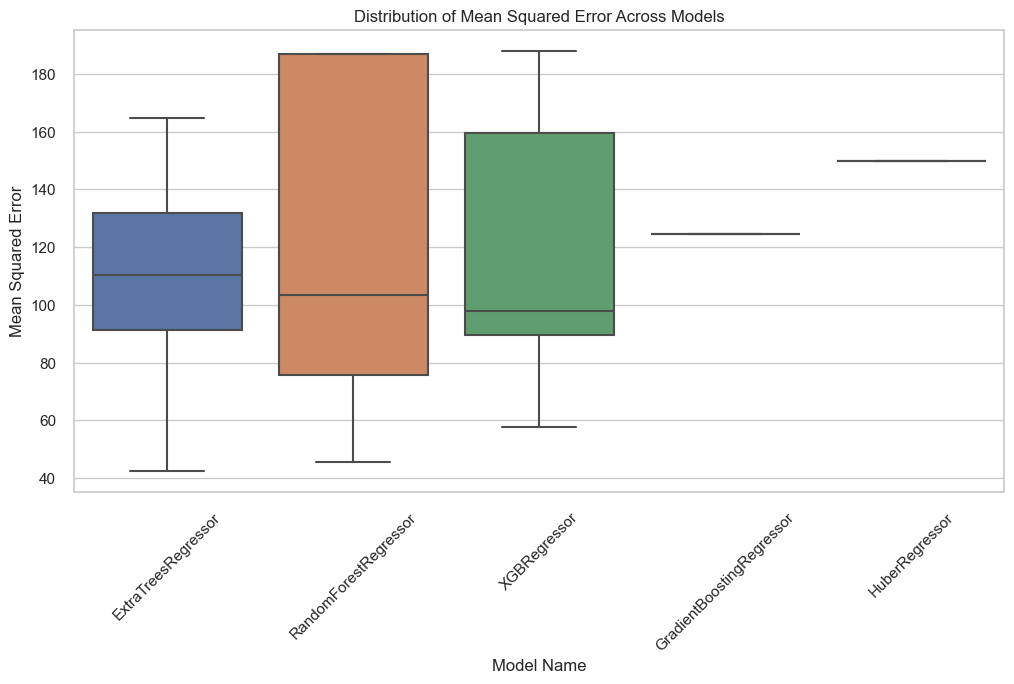

In [84]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model Name', y='Mean Squared Error', data=batch_concat)
plt.title('Distribution of Mean Squared Error Across Models')
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.show()


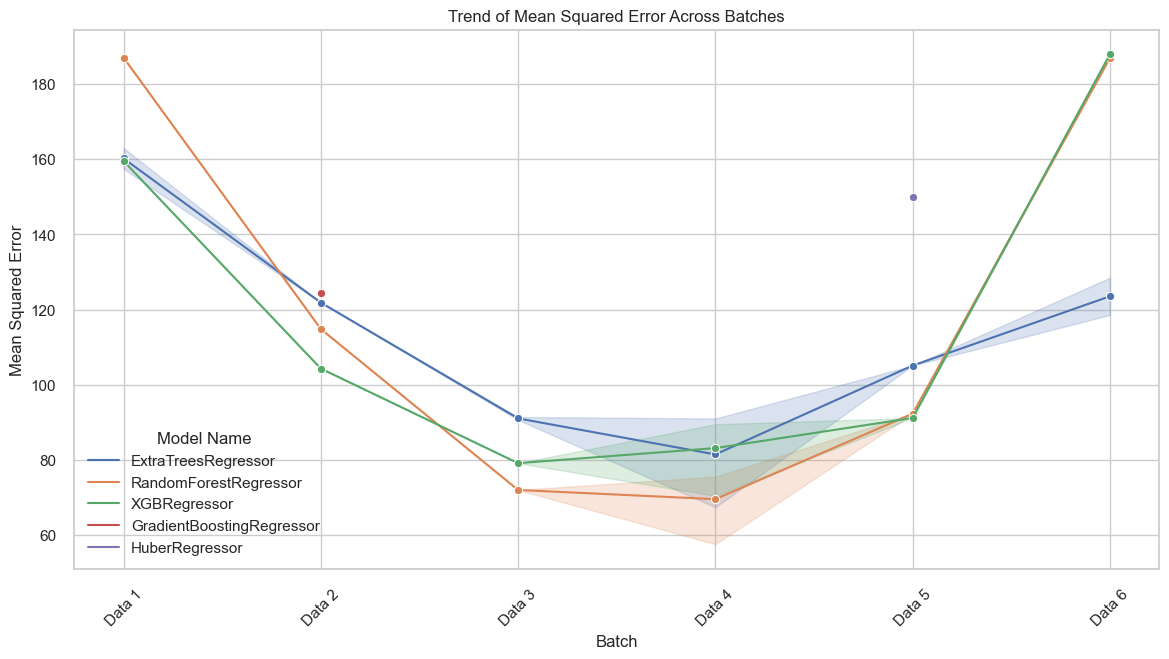

In [85]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Batch', y='Mean Squared Error', hue='Model Name', marker='o', data=batch_concat)
plt.title('Trend of Mean Squared Error Across Batches')
plt.xticks(rotation=45)
plt.legend(title='Model Name')
plt.show()


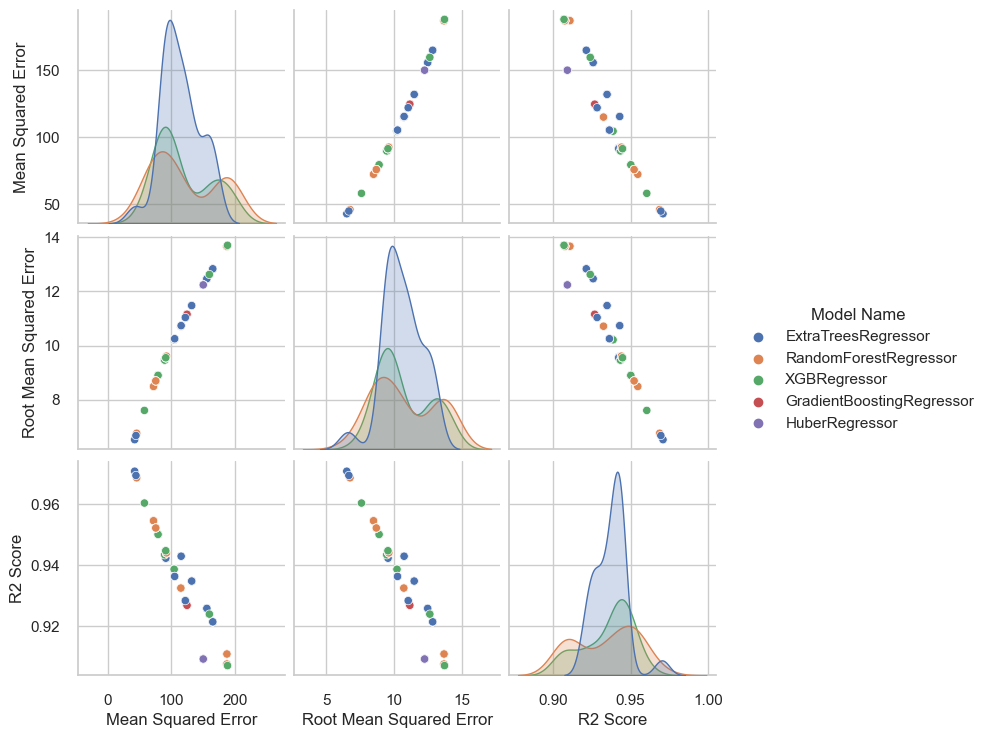

In [86]:
sns.pairplot(data=batch_concat, vars=['Mean Squared Error', 'Root Mean Squared Error', 'R2 Score'], hue='Model Name')
plt.show()


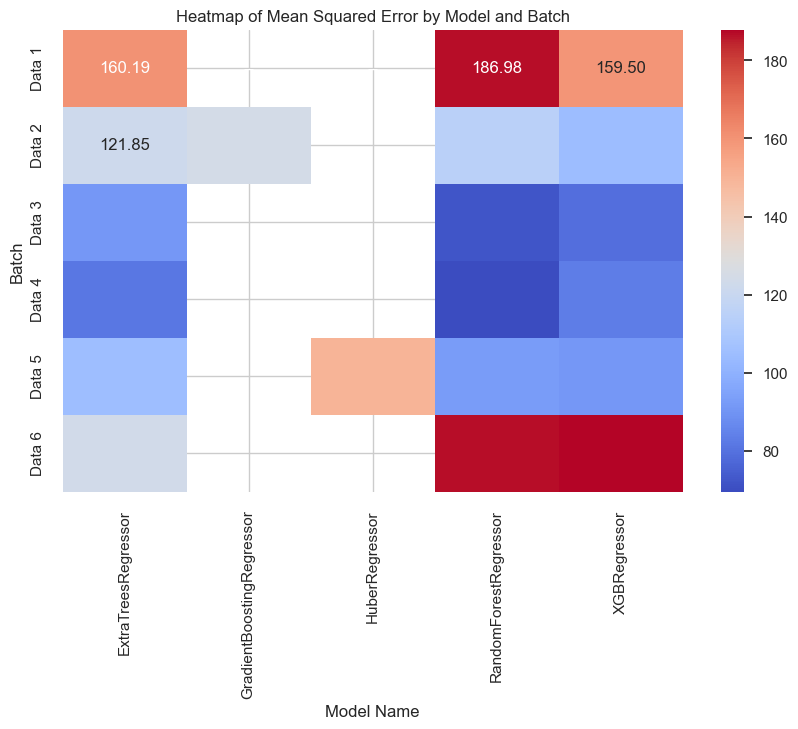

In [87]:
# Creating a pivot table for the heatmap
performance_pivot = batch_concat.pivot_table(values='Mean Squared Error', index='Batch', columns='Model Name')

plt.figure(figsize=(10, 6))
sns.heatmap(performance_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Heatmap of Mean Squared Error by Model and Batch')
plt.show()


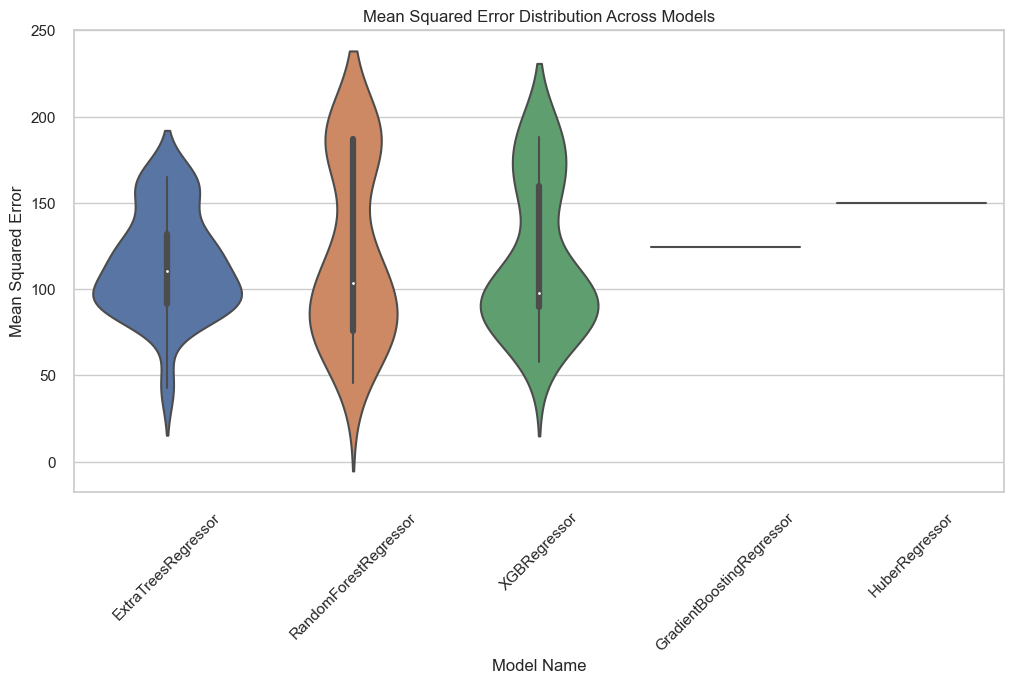

In [88]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Model Name', y='Mean Squared Error', data=batch_concat)
plt.title('Mean Squared Error Distribution Across Models')
plt.xticks(rotation=45)
plt.show()


<a id="6"></a> <br>
## Model Evaluation

> View Performance metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


def print_regression_performance_report(
    model, X_test, y_test, sarimax_model=True, action="set"):
    """
    Program: print_regression_performance_report
    Author: Siraprapa W.
    Purpose: Print standard regression metrics report and generate visualizations.
    """

    if action == "set":
        if "input_Timepoint (hr)" in X_test.columns:
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_test = set_reset_index(X_test, action=action)
    if sarimax_model == True:
        y_pred = model.get_forecast(
            steps=len(X_test), exog=X_test
        ).predicted_mean.values
    else:
        y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error (MSE): {:.4f}".format(mse))
    print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
    print("R-squared (R2): {:.4f}".format(r2))
    # Add additional regression metrics and visualizations here
    # Plot actual vs predicted values
    plt.scatter(y_test, y_pred)
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
    )

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

    return mse, rmse, r2, y_pred

In [ ]:
mse, rmse, r2, y_pred = print_regression_performance_report(
    model_fit, X_test, y_test, True, "set"
)  # SARIMAX model

In [ ]:
mse, rmse, r2, y_pred = print_regression_performance_report(
    xgb_model_fit, X_test, y_test, False, "reset"
)

In [ ]:
# from yellowbrick.datasets import load_concrete
# from yellowbrick.regressor import ResidualsPlot


# visualizer = ResidualsPlot(model)

# visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# visualizer.show()                 # Finalize and render the figure

In [ ]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, test_scores = learning_curve(estimator=xgb_model_fit, X=X_train, y=y_train, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes, train_scores_mean, label='Training score')
# plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
# plt.xlabel('Training examples')
# plt.ylabel('Score')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()


In [ ]:
from yellowbrick.regressor import ResidualsPlot
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager


def residual_plot(model, X_train, y_train, X_test, y_test, action="set"):
    """
    Program: print_regression_performance_report
    Author: Siraprapa W.

    Purpose: Print standard regression metrics report and generate visualizations.
    """
    if action == "set":
        if "input_Timepoint (hr)" in X_test.columns:
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_test = set_reset_index(X_test, action=action)

    visualizer = ResidualsPlot(xgb_model_fit, hist=False)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()  # Finalize and render the figure

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


xgb_model_fit.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model_fit.predict(X_train)
y_test_pred = xgb_model_fit.predict(X_test)

# Compute the residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Calculate the R-squared values
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create the residual plots
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plots for training and testing residuals
sns.scatterplot(
    x=y_train_pred,
    y=train_residuals,
    ax=ax,
    color="blue",
    alpha=0.5,
    label=f"Train R² = {train_r2:.3f}",
)
sns.scatterplot(
    x=y_test_pred,
    y=test_residuals,
    ax=ax,
    color="green",
    alpha=0.5,
    label=f"Test R² = {test_r2:.3f}",
)

# Plot a line at 0 for residuals
ax.axhline(y=0, color="black", linestyle="--")

# Annotations and labels
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
ax.set_title("Residuals for Ridge Model")

# Plot histograms for residuals
sns.histplot(
    train_residuals,
    kde=True,
    color="blue",
    ax=ax,
    stat="density",
    element="step",
    alpha=0.3,
)
sns.histplot(
    test_residuals,
    kde=True,
    color="green",
    ax=ax,
    stat="density",
    element="step",
    alpha=0.3,
)

# Show legend and plot
ax.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and data
models = ["Linear Regression", "XGBoost", "SARIMAX"]

mse = [
    # Data 1
    [118.59194508422084, 40.62359283670584, 107.23563874099641],
    # Data 2
    [37.84093283149445, 247.9630739752672, 109.32773828962365],
    # Data 3
    [37.84093283149445, 247.9630739752672, 109.32773828962365],
]

rmse = [
    # Data 1
    [10.889992887243814, 6.373664004064368, 10.355464197272685],
    # Data 2
    [6.151498421644473, 15.74684330192141, 10.45599054559747],
    # Data 3
    [6.151498421644473, 15.74684330192141, 10.45599054559747],
]

r2 = [
    # Data 1
    [0.8962165146364349, 0.9644490353068284, 0.9061547701589259],
    # Data 2
    [0.9679486878029661, 0.7899750005448363, 0.9073992840683901],
    # Data 3
    [0.9679486878029661, 0.7899750005448363, 0.9073992840683901],
]


batches = ["Data 1", "Data 2", "Data 3"]

# Create the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the positions of bars
index = np.arange(len(models))
bar_width = 0.2
opacity = 0.8

# Plotting MSE and RMSE as bar plots
for i, model in enumerate(models):
    mse_values = [mse[j][i] for j in range(len(batches))]
    rmse_values = [rmse[j][i] for j in range(len(batches))]

    axs[0].bar(index + i * bar_width, mse_values, bar_width, alpha=opacity, label=model)
    axs[1].bar(
        index + i * bar_width, rmse_values, bar_width, alpha=opacity, label=model
    )

# Plotting R2 as a horizontal bar plot
for i, model in enumerate(models):
    r2_values = [r2[j][i] for j in range(len(batches))]
    positions = index + i * bar_width  # Horizontal bar positions
    axs[2].barh(positions, r2_values, bar_width, alpha=opacity, label=model)

# Setting the labels and titles

# axs[0].set_title('MSE by Model')
# axs[1].set_title('RMSE by Model')
# axs[2].set_title('R2 by Model')
axs[0].set_xticks(index + bar_width / 2, batches)
axs[1].set_xticks(index + bar_width / 2, batches)
axs[2].set_yticks(index + bar_width / 2, batches)  # Adjust for horizontal bar plot
axs[0].set_ylabel("MSE")
axs[1].set_ylabel("RMSE")
axs[2].set_xlabel("R-squared")  # X-axis for horizontal bar plot
# axs[2].set_xlabel(r'$R^2$')  # X-axis for horizontal bar plot

# Adding legends
axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")
# Use bbox_to_anchor to move the legend slightly lower than the center right
axs[2].legend(loc="center right", bbox_to_anchor=(1, 0.32))

# remove grids
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
#Regression performance report 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


mse, rmse, r2, y_pred = print_regression_performance_report(model_fit, X_test, y_test)

#Regression
    # Error = Actual value - Predicted value

    # MSE (Mean Square Error)
        # The square of the error over all samples is called Mean Squarred Error(MSE).
        # MSE = SQUARE(Actual value - Predicted value)/Number of Samples
    #RMSE (Root Mean Square Error)
    # MAE (Mean Absolute Error)
        # MAE = ABSOLUTE (Actual value - Predicted Value)


In [ ]:
import joblib

# Specify the filename for the saved model
model_filename = "sarimax_model.joblib"
joblib.dump(
    model_fit_2, f"models/{model_filename}"
)  # Save the trained SARIMAX model to file


# save the scaler
scaler_filename = "scaler.joblib"
joblib.dump(scaler, f"models/{scaler_filename}")  # Save the trained scaler to file


# Open a file in write-binary (wb) mode and save the model

print(f"Model saved to {model_filename}")

>> Learning Curve (Access the Bias and Variance) - Model Diagnostics

- `Bias` - error in the training data

- `Variance` -> difference in the errors between the train and test data. (i.e.,  it examines how the model's performance varies between the training data and unseen data (like a validation set).  If the model performs well on the training data but poorly on the validation/test data, it suggests high variance)


`High Bias (will also have High Variance) -> Underfitting:` The model is too simple and doesn't capture the complexities of the data well, leading to poor performance on both training and testing datasets.

`Low Bias + High Variance -> Overfitting:` The model is too complex, fitting too closely to the training data, including its noise and outliers. It performs well on training data but poorly on unseen data.

`Low Bias + Low Variance -> Ideal Model:` This is the desired outcome. The model accurately captures the underlying patterns in the data (low bias) and generalizes well to unseen data (low variance).

<p align="center">
  <img src="learning-curves.png" alt="Example Image"/>
</p>



In [ ]:

#check Bias and Variance using Learnng Curve 


from yellowbrick.model_selection import LearningCurve

sizes = np.linspace(0.1, 1.0, 10) # Define the training set sizes to plot the learning curve

visualizer = LearningCurve(
    xgb_model_fit, cv=5, scoring='r2', train_sizes=sizes, n_jobs=4  #or use scoring = 'neg_mean_squared_error'
        )
visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


# To fix high bias (underfitting):
    # get additional features or increasing the size of the model 
    # Adding polynomial features is a form of feature engineering that can increase the complexity of the model
    # decrease the regularization parameter (lambda) to allow the model's learning algorithm to fit the data more flexibly, 
        # thereby potentially reducing bias

# To fix high variance (overfitting):
    # Obtaining more training samples can help the model generalize better.
    # Simplifying the model by reducing the number of features (feature selection) can prevent the model from fitting noise in the 
        # training data.
    # Increasing the regularization parameter (lambda) adds a penalty to the model complexity, which can help in preventing overfitting.


> Cross Validation Scores

In [ ]:
from sklearn.model_selection import (
    learning_curve,
    cross_val_score,
    KFold,
    train_test_split,
)
from yellowbrick.model_selection import (
    CVScores,
)  # visualizing the cross validation scores

# check Bias and Variance using Cross Validation

cv = 5  # or # Create a cross-validation object:
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

visualizer = CVScores(xgb_model_fit, cv=cv, scoring="neg_mean_squared_error")

visualizer.fit(X_train, y_train)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

> Plot Validation Curves (to analyse the impact of each Hyperparameter)

In [ ]:
# to analyze the impact of varying hyperparameter values on the model's performance using Validation curve
# the validation curve is useful for hyperparameter tuning, while the learning curve is used to assess bias and variance.

# Using validation curves is a fundamental aspect of machine learning model tuning, as it provides valuable insights into how
# hyperparameters influence model performance, aiding in the selection of the most appropriate model settings.

from sklearn.model_selection import validation_curve


# the hyperparameter used here is 'max_depth'. A hyperparameter for the model ExtraTreeRegressor

plot_validation_curve(
    model, X_train, y_train, param_name="max_depth", cv=5, scoring="r2"
)

In [ ]:
from yellowbrick.model_selection import ValidationCurve

# cv = StratifiedKFold(4)
viz = ValidationCurve(
    xgb_model_fit,
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=10,
    scoring="r2",
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

>> Analyze Error Distribution

In [ ]:
# if the errors are normally distributed around zero, it may indicate that the model is making unbiased predictions. 
# If there is a pattern or trend in the errors, it may suggest that the model has systematic biases or is making 
# consistent errors in certain regions of the input space


analyze_error_distribution(y_val, y_pred)

>> Error Analysis - Diagnostics

In [ ]:
#Error analysis is the process of analyzing the errors made by a machine learning model and identifying the patterns 
# or trends that may be causing the errors. The goal of error analysis is to gain insight into the behavior of the 
# model and identify areas for improvement. 

# The steps involved in error analysis:
    # 1. Collect error data - Gather instances where the model made incorrect predictions.
    # 2. Categorize errors - Classify errors into meaningful categories.
    # 3. Identify patterns - Look for commonalities or trends among the errors.
    # 4. Analyze causes - Investigate potential reasons behind these patterns.
    # 5. Prioritize fixes - Decide which errors to address first based on their impact.

    
# Based on the insights gained from the error analysis, you can perform the following.

# False negatives: 
    # To fix this issue, you may consider the following:
        # Increase the weight of the features that are more indicative of churn for low-usage customers, 
            # such as frequency of usage or specific product usage. (adjust the model parameters)
        # Add new features that may be predictive of churn, such as customer sentiment or customer service interactions.
        # Use a different model architecture that is better suited for handling imbalanced data, such as a decision tree 
            # or ensemble model. 


# False positives:
    # To fix this issue, you may consider the following:
        # Decrease the weight of features that are causing false positives, such as age or income, if they are not as 
            # indicative of churn for low-usage customers. (adjust the model parameters)
        # Remove features that are causing false positives altogether, if they are not providing significant value to the 
            # model.
        # Increase the size of the training dataset to capture a more representative sample of customers who do not churn, 
            # which may help the model learn more accurately which customers are likely to churn.


<a id="8"></a> <br>
## Model Optimization

>> Auto Hyperparameter Optimization using Optuna

In [ ]:
from sklearn.svm import SVC
import optuna

SVC().get_params()

In [ ]:
# Set the logging level for Optuna to WARNING
# logging.getLogger('optuna').setLevel(logging.WARNING)


def objective(trial):
    # Define the hyperparameters' search space
    C = trial.suggest_loguniform("C", 1e-4, 1e4)
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    degree = (
        trial.suggest_int("degree", 1, 5) if kernel == "poly" else 3
    )  # degree is only used for 'poly' kernel

    # Create the SVM model
    model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree, probability=True)

    cv = StratifiedKFold(n_splits=10, random_state=11, shuffle=True)

    # Perform cross-validation and compute the average AUC score
    scores = cross_val_score(
        model, train_data, train_labels, scoring="roc_auc", n_jobs=-1, cv=cv
    )
    avg_auc_test = np.mean(scores)

    return avg_auc_test


# Create and run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Best hyperparameters
best_hyperparams = study.best_trial.params
# print('Best Hyperparameters:', best_hyperparams)

In [ ]:
# Best hyperparameters obtained from Optuna
best_C_svm = best_hyperparams["C"]
best_kernel = best_hyperparams["kernel"]
best_gamma = best_hyperparams["gamma"]
best_degree = best_hyperparams["degree"]


print("Best C (svm): {}".format(best_C_svm))
print("Best kernel: {}".format(best_kernel))
print("Best gamma: {}".format(best_gamma))
print("Best degree: {}".format(best_degree))

tuned_svm_model = SVC(
    C=best_C_svm,
    kernel=best_kernel,
    gamma=best_gamma,
    degree=best_degree,
    probability=True,
)

tuned_svm_model.fit(train_data, train_labels)

dump(tuned_svm_model, "models/tuned_model/tuned_support_vector.joblib")

In [ ]:
y_pred, ACC, PC, RC, FS, AP, roc_auc, gini = (
    print_classification_performance2class_report(
        tuned_svm_model, valid_data, valid_labels
    )
)